In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
tb.seed_everything(0)

In [3]:
EXPERIMENT_NAME = '1127-LSTM-win120'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [4]:
WINDOW_SIZE = 120

In [5]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile, window_size, stride):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size
        
        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            self.indexes.append((i, i + window_size))
            i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        sx, tx = self.indexes[idx]
        sy, ty = sx + 18, tx + 18
        x = self.csv.iloc[sx:tx][self.xcols].to_numpy()
        y = self.csv.iloc[sy:ty][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 300, 3

        return x, y

In [6]:
ds_train = [CSVSequentialDataset(f, window_size=WINDOW_SIZE, stride=5) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f, window_size=WINDOW_SIZE, stride=5) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [7]:
len(ds_train), len(ds_test)

(11071, 10671)

In [8]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([120, 6]), torch.Size([120, 3]))

In [9]:
x, y = ds_train[0]

In [10]:
x.shape

torch.Size([120, 6])

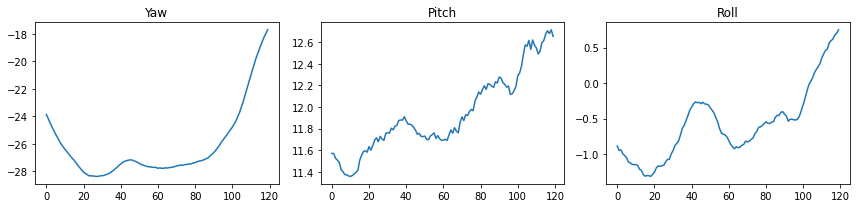

In [11]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.plot(x[:, 0])
plt.title('Yaw')

plt.subplot(1, 3, 2)
plt.plot(x[:, 1])
plt.title('Pitch')

plt.subplot(1, 3, 3)
plt.plot(x[:, 2])
plt.title('Roll')

plt.tight_layout()
plt.show()

# 모델 생성

StackedLSTM Bidirectional

In [12]:
class M2M_LSTM(nn.Module):
    def __init__(self):
        super(M2M_LSTM, self).__init__()

        self.rnn = nn.LSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           batch_first=True,
                           dropout=0.2,
                           bidirectional=True)

        self.out = nn.LSTM(input_size=128, 
                           hidden_size=3, 
                           num_layers=1, 
                           batch_first=True, 
                           dropout=0, 
                           bidirectional=False)
        self.fc = nn.Linear(128, 3)

    def forward(self, x):
        x, (hiddens, cells) = self.rnn(x) # B, S, 128
        #x, (hiddens, cells) = self.out(x) # B, S, 3
        hs = []
        for i in range(x.shape[1]):
            h = self.fc(x[:, i])
            hs.append(h)
        h = torch.stack(hs, 1)

        return h

In [13]:
model = M2M_LSTM().cuda()

In [14]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [15]:
class HPMetric(tb.metrics.InvisibleMetric):
    def __init__(self, name: str):
        super(HPMetric, self).__init__(name)

        self.diff = []

    def on_valid_epoch_end(self, epoch: int, logs: dict):
        # RMS, 99% tile 출력
        yaw_v, pitch_v, roll_v, rms_v, tile99_v = self._calc_values(self.diff)

        print(f'                  validation')
        print(f' - Yaw          : {yaw_v:10f}')
        print(f' - Pitch        : {pitch_v:10f}')
        print(f' - Roll         : {roll_v:10f}')
        print(f' - RMS          : {rms_v:10f}')
        print(f' - 99% Tile     : {tile99_v:10f}')

        self.diff.clear()

    def get_value(self, outputs: torch.Tensor, targets: torch.Tensor, is_train: bool):
        if not is_train:
            self.diff.append((outputs - targets).mean(1).detach().cpu())  # (B, S, 3) --> (B, 3)

    @staticmethod
    def _calc_values(diff):
        diff = torch.cat(diff).abs_()  # (D, 3)
        rms = (diff.square().sum(1) / 3).sqrt()
        tile = rms.flatten().numpy()
        tile99 = np.percentile(tile, 99)
        
        mrms = rms.mean()
        
        # diff = radian2degree(diff)
        #tile = diff.flatten().numpy()
        #tile99 = np.percentile(tile, 99)

        mdiff = diff.mean(dim=0)
        #rms = (mdiff.square().sum() / 3).sqrt()

        return mdiff[0].item(), mdiff[1].item(), mdiff[2].item(), mrms.item(), tile99

In [16]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           HPMetric('hp_metric')]

In [17]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0], patience=3),
             tb.callbacks.SaveCheckpoint({'model': model}, metrics[0], CHECKPOINT_DIR, 'best-ckpt.pth')]

In [18]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [19]:
trainer.fit(ds_train, ds_test, num_epochs=200, batch_size=256, shuffle=True, pin_memory=True)

[0002/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from inf to 235.8046284630185
                  validation
 - Yaw          :  18.209953
 - Pitch        :  10.195655
 - Roll         :   2.426534
 - RMS          :  13.053984
 - 99% Tile     :  27.050447


[0003/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 235.8046284630185 to 192.67763237726123
                  validation
 - Yaw          :  15.911419
 - Pitch        :   9.012309
 - Roll         :   2.434345
 - RMS          :  11.554173
 - 99% Tile     :  25.482594


[0004/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 192.67763237726123 to 153.15524855114163
                  validation
 - Yaw          :  13.439418
 - Pitch        :   8.215492
 - Roll         :   2.354314
 - RMS          :  10.067547
 - 99% Tile     :  23.503929


[0005/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 153.15524855114163 to 126.16457589467366
                  validation
 - Yaw          :  11.705969
 - Pitch        :   7.674967
 - Roll         :   2.244334
 - RMS          :   8.948116
 - 99% Tile     :  21.623724


[0006/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 126.16457589467366 to 107.01545801616851
                  validation
 - Yaw          :  10.370607
 - Pitch        :   7.194466
 - Roll         :   2.240994
 - RMS          :   8.104319
 - 99% Tile     :  20.517000


[0007/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 107.01545801616851 to 92.87267734890891
                  validation
 - Yaw          :   9.188320
 - Pitch        :   6.840122
 - Roll         :   2.252495
 - RMS          :   7.449759
 - 99% Tile     :  19.538926


[0008/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 92.87267734890891 to 78.68833530516852
                  validation
 - Yaw          :   8.082277
 - Pitch        :   6.274278
 - Roll         :   2.243539
 - RMS          :   6.739577
 - 99% Tile     :  18.353258


[0009/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 78.68833530516852 to 66.74144390651158
                  validation
 - Yaw          :   7.226402
 - Pitch        :   5.563637
 - Roll         :   2.236682
 - RMS          :   6.068611
 - 99% Tile     :  17.329950


[0010/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 66.74144390651158 to 56.97174483253842
                  validation
 - Yaw          :   6.211850
 - Pitch        :   5.253831
 - Roll         :   2.249023
 - RMS          :   5.509966
 - 99% Tile     :  16.269660


[0011/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 56.97174483253842 to 49.084238370259605
                  validation
 - Yaw          :   5.633984
 - Pitch        :   4.855975
 - Roll         :   2.255434
 - RMS          :   5.075986
 - 99% Tile     :  15.490222


[0012/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 49.084238370259605 to 42.46081189882188
                  validation
 - Yaw          :   5.306212
 - Pitch        :   4.282553
 - Roll         :   2.266616
 - RMS          :   4.688795
 - 99% Tile     :  14.727848


[0013/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 42.46081189882188 to 35.42476581391833
                  validation
 - Yaw          :   4.465352
 - Pitch        :   3.693047
 - Roll         :   2.249701
 - RMS          :   4.125103
 - 99% Tile     :  13.945538


[0014/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 35.42476581391833 to 30.382690531866892
                  validation
 - Yaw          :   4.084827
 - Pitch        :   3.313365
 - Roll         :   2.248132
 - RMS          :   3.812726
 - 99% Tile     :  13.239458


[0015/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 30.382690531866892 to 26.011926787240164
                  validation
 - Yaw          :   3.540429
 - Pitch        :   2.952351
 - Roll         :   2.236752
 - RMS          :   3.457930
 - 99% Tile     :  12.450292


[0016/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 26.011926787240164 to 22.23664735044752
                  validation
 - Yaw          :   3.055842
 - Pitch        :   2.670104
 - Roll         :   2.220230
 - RMS          :   3.132455
 - 99% Tile     :  11.684175


[0017/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 22.23664735044752 to 19.704634286108472
                  validation
 - Yaw          :   3.042125
 - Pitch        :   2.457873
 - Roll         :   2.221213
 - RMS          :   3.016486
 - 99% Tile     :  10.946892


[0018/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 19.704634286108472 to 17.086164014680044
                  validation
 - Yaw          :   2.575687
 - Pitch        :   2.225807
 - Roll         :   2.208432
 - RMS          :   2.749830
 - 99% Tile     :  10.358132


[0019/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 17.086164014680044 to 15.4872641818864
                  validation
 - Yaw          :   2.397912
 - Pitch        :   2.208949
 - Roll         :   2.219008
 - RMS          :   2.667806
 - 99% Tile     :   9.855052


[0020/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 15.4872641818864 to 13.475546229453315
                  validation
 - Yaw          :   1.967591
 - Pitch        :   1.873329
 - Roll         :   2.193111
 - RMS          :   2.393678
 - 99% Tile     :   9.496765


[0021/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 13.475546229453315 to 12.07818154210136
                  validation
 - Yaw          :   1.826135
 - Pitch        :   1.683598
 - Roll         :   2.177956
 - RMS          :   2.258917
 - 99% Tile     :   9.091623


[0022/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 12.07818154210136 to 11.317228572709222
                  validation
 - Yaw          :   1.771624
 - Pitch        :   1.680222
 - Roll         :   2.174250
 - RMS          :   2.224472
 - 99% Tile     :   8.641909


[0023/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 11.317228572709222 to 10.139175962834127
                  validation
 - Yaw          :   1.451862
 - Pitch        :   1.523923
 - Roll         :   2.137539
 - RMS          :   2.053096
 - 99% Tile     :   8.346278


[0024/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 10.139175962834127 to 9.621930247261409
                  validation
 - Yaw          :   1.543004
 - Pitch        :   1.482088
 - Roll         :   2.093898
 - RMS          :   2.036510
 - 99% Tile     :   8.006323


[0025/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 9.621930247261409 to 8.900141534351167
                  validation
 - Yaw          :   1.347553
 - Pitch        :   1.458392
 - Roll         :   2.092911
 - RMS          :   1.948740
 - 99% Tile     :   7.720876


[0026/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 8.900141534351167 to 8.219011471385048
                  validation
 - Yaw          :   1.142593
 - Pitch        :   1.425649
 - Roll         :   2.067683
 - RMS          :   1.854175
 - 99% Tile     :   7.311917


[0027/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.359693
 - Pitch        :   1.898323
 - Roll         :   2.118024
 - RMS          :   2.067349
 - 99% Tile     :   7.120589


[0028/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 8.219011471385048 to 7.483566142263866
                  validation
 - Yaw          :   1.152738
 - Pitch        :   1.161386
 - Roll         :   2.018778
 - RMS          :   1.756361
 - 99% Tile     :   6.889227


[0029/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 7.483566142263866 to 7.302970962865012
                  validation
 - Yaw          :   1.132842
 - Pitch        :   1.289679
 - Roll         :   1.982666
 - RMS          :   1.763518
 - 99% Tile     :   6.704381


[0030/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.318937
 - Pitch        :   1.172203
 - Roll         :   2.013513
 - RMS          :   1.806075
 - 99% Tile     :   6.634123


[0031/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 7.302970962865012 to 6.888188021523612
                  validation
 - Yaw          :   1.019893
 - Pitch        :   1.284387
 - Roll         :   1.962388
 - RMS          :   1.701744
 - 99% Tile     :   6.421342


[0032/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.611468
 - Pitch        :   1.486253
 - Roll         :   1.911987
 - RMS          :   1.965890
 - 99% Tile     :   6.302891


[0033/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   2.167185
 - Pitch        :   3.172165
 - Roll         :   2.547524
 - RMS          :   3.035194
 - 99% Tile     :   8.758258


[0034/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.978394
 - Pitch        :   1.428164
 - Roll         :   2.087408
 - RMS          :   1.814373
 - 99% Tile     :   6.953422


[0035/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.767827
 - Pitch        :   1.299337
 - Roll         :   1.987229
 - RMS          :   1.652939
 - 99% Tile     :   6.601246


[0036/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 6.888188021523612 to 6.648114940949848
                  validation
 - Yaw          :   0.906677
 - Pitch        :   1.179839
 - Roll         :   1.873911
 - RMS          :   1.603795
 - 99% Tile     :   6.443439


[0037/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 6.648114940949848 to 6.283346712589264
                  validation
 - Yaw          :   0.848682
 - Pitch        :   1.114938
 - Roll         :   1.796201
 - RMS          :   1.532011
 - 99% Tile     :   6.251014


[0038/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 6.283346712589264 to 5.771191640978768
                  validation
 - Yaw          :   0.732429
 - Pitch        :   1.032656
 - Roll         :   1.658770
 - RMS          :   1.396117
 - 99% Tile     :   6.002643


[0039/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.771191640978768 to 5.551582457054229
                  validation
 - Yaw          :   0.897595
 - Pitch        :   1.047906
 - Roll         :   1.545630
 - RMS          :   1.401355
 - 99% Tile     :   5.842950


[0040/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.551582457054229 to 5.062802729152498
                  validation
 - Yaw          :   0.765469
 - Pitch        :   0.917192
 - Roll         :   1.409450
 - RMS          :   1.246276
 - 99% Tile     :   5.707397


[0041/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.062802729152498 to 4.770362466573715
                  validation
 - Yaw          :   0.865669
 - Pitch        :   0.850124
 - Roll         :   1.252274
 - RMS          :   1.187402
 - 99% Tile     :   5.498909


[0042/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 4.770362466573715 to 4.432819543849854
                  validation
 - Yaw          :   0.735608
 - Pitch        :   0.896827
 - Roll         :   1.094529
 - RMS          :   1.084280
 - 99% Tile     :   5.381657


[0043/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 4.432819543849854 to 4.10278442360106
                  validation
 - Yaw          :   0.697644
 - Pitch        :   0.767967
 - Roll         :   1.026723
 - RMS          :   0.990606
 - 99% Tile     :   5.301882


[0044/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 4.10278442360106 to 3.9148820212909152
                  validation
 - Yaw          :   0.671461
 - Pitch        :   0.782835
 - Roll         :   0.888452
 - RMS          :   0.927038
 - 99% Tile     :   5.294485


[0045/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 3.9148820212909152 to 3.742053121328354
                  validation
 - Yaw          :   0.737145
 - Pitch        :   0.725061
 - Roll         :   0.821100
 - RMS          :   0.904350
 - 99% Tile     :   5.114311


[0046/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 3.742053121328354 to 3.664281426441102
                  validation
 - Yaw          :   0.736667
 - Pitch        :   0.756148
 - Roll         :   0.774806
 - RMS          :   0.892066
 - 99% Tile     :   5.069586


[0047/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 3.664281426441102 to 3.6102514884301593
                  validation
 - Yaw          :   0.665138
 - Pitch        :   0.784303
 - Roll         :   0.786229
 - RMS          :   0.878999
 - 99% Tile     :   4.977240


[0048/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 3.6102514884301593 to 3.4895198260034834
                  validation
 - Yaw          :   0.807821
 - Pitch        :   0.695956
 - Roll         :   0.694774
 - RMS          :   0.870191
 - 99% Tile     :   4.896773


[0049/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 3.4895198260034834 to 3.347930683976128
                  validation
 - Yaw          :   0.665581
 - Pitch        :   0.756034
 - Roll         :   0.710328
 - RMS          :   0.829656
 - 99% Tile     :   4.835675


[0050/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 3.347930683976128 to 3.2278214721452634
                  validation
 - Yaw          :   0.638469
 - Pitch        :   0.637031
 - Roll         :   0.626113
 - RMS          :   0.755993
 - 99% Tile     :   4.805463


[0051/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 3.2278214721452634 to 3.1497031414792653
                  validation
 - Yaw          :   0.595842
 - Pitch        :   0.689084
 - Roll         :   0.621755
 - RMS          :   0.749534
 - 99% Tile     :   4.768624


[0052/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 3.1497031414792653 to 3.0729604689847854
                  validation
 - Yaw          :   0.607590
 - Pitch        :   0.651660
 - Roll         :   0.591835
 - RMS          :   0.723717
 - 99% Tile     :   4.732751


[0053/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.694506
 - Pitch        :   0.636599
 - Roll         :   0.603192
 - RMS          :   0.756376
 - 99% Tile     :   4.712193


[0054/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.874347
 - Pitch        :   0.726858
 - Roll         :   0.647812
 - RMS          :   0.879176
 - 99% Tile     :   4.687824


[0055/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 3.0729604689847854 to 3.020633889805703
                  validation
 - Yaw          :   0.688712
 - Pitch        :   0.645023
 - Roll         :   0.594040
 - RMS          :   0.750124
 - 99% Tile     :   4.632739


[0056/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 3.020633889805703 to 2.918859556317329
                  validation
 - Yaw          :   0.686013
 - Pitch        :   0.578254
 - Roll         :   0.557407
 - RMS          :   0.724016
 - 99% Tile     :   4.542506


[0057/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.918859556317329 to 2.884089946037247
                  validation
 - Yaw          :   0.650714
 - Pitch        :   0.613390
 - Roll         :   0.549292
 - RMS          :   0.711233
 - 99% Tile     :   4.528385


[0058/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.884089946037247 to 2.7985721287273226
                  validation
 - Yaw          :   0.578371
 - Pitch        :   0.583729
 - Roll         :   0.531134
 - RMS          :   0.668044
 - 99% Tile     :   4.468654


[0059/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.7985721287273226 to 2.7392790622654415
                  validation
 - Yaw          :   0.545520
 - Pitch        :   0.557139
 - Roll         :   0.557546
 - RMS          :   0.654899
 - 99% Tile     :   4.372537


[0060/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.7392790622654415 to 2.6962539681366513
                  validation
 - Yaw          :   0.592947
 - Pitch        :   0.554568
 - Roll         :   0.512939
 - RMS          :   0.658362
 - 99% Tile     :   4.263685


[0061/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.6962539681366513 to 2.674163152774175
                  validation
 - Yaw          :   0.642206
 - Pitch        :   0.589631
 - Roll         :   0.527541
 - RMS          :   0.690981
 - 99% Tile     :   4.204389


[0062/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.674163152774175 to 2.6655646370989934
                  validation
 - Yaw          :   0.687908
 - Pitch        :   0.561527
 - Roll         :   0.500685
 - RMS          :   0.694833
 - 99% Tile     :   4.032441


[0063/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.6655646370989934 to 2.622187662692297
                  validation
 - Yaw          :   0.635304
 - Pitch        :   0.577878
 - Roll         :   0.498385
 - RMS          :   0.669201
 - 99% Tile     :   4.080723


[0064/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.780133
 - Pitch        :   0.591743
 - Roll         :   0.477908
 - RMS          :   0.728025
 - 99% Tile     :   4.176802


[0065/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.622187662692297 to 2.5422530351650146
                  validation
 - Yaw          :   0.585986
 - Pitch        :   0.564997
 - Roll         :   0.491751
 - RMS          :   0.641621
 - 99% Tile     :   4.160875


[0066/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.5422530351650146 to 2.481782927399589
                  validation
 - Yaw          :   0.614245
 - Pitch        :   0.574932
 - Roll         :   0.466471
 - RMS          :   0.649052
 - 99% Tile     :   3.965344


[0067/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.714966
 - Pitch        :   0.533449
 - Roll         :   0.483978
 - RMS          :   0.683629
 - 99% Tile     :   4.106642


[0068/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.751060
 - Pitch        :   0.535918
 - Roll         :   0.489732
 - RMS          :   0.700416
 - 99% Tile     :   3.741571


[0069/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.481782927399589 to 2.351361530877295
                  validation
 - Yaw          :   0.599042
 - Pitch        :   0.560384
 - Roll         :   0.454957
 - RMS          :   0.631067
 - 99% Tile     :   3.765579


[0070/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.648408
 - Pitch        :   0.524627
 - Roll         :   0.455376
 - RMS          :   0.642765
 - 99% Tile     :   3.878059


[0071/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.780282
 - Pitch        :   0.541818
 - Roll         :   0.449781
 - RMS          :   0.698830
 - 99% Tile     :   3.743135


[0072/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.688106
 - Pitch        :   0.509710
 - Roll         :   0.421464
 - RMS          :   0.639314
 - 99% Tile     :   4.025691


[0073/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.351361530877295 to 2.2591065221599167
                  validation
 - Yaw          :   0.634810
 - Pitch        :   0.501525
 - Roll         :   0.413876
 - RMS          :   0.609916
 - 99% Tile     :   3.724742


[0074/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.2591065221599167 to 2.197869712752955
                  validation
 - Yaw          :   0.564206
 - Pitch        :   0.482608
 - Roll         :   0.421894
 - RMS          :   0.573720
 - 99% Tile     :   3.770105


[0075/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.586663
 - Pitch        :   0.529444
 - Roll         :   0.420512
 - RMS          :   0.599543
 - 99% Tile     :   3.756357


[0076/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.639797
 - Pitch        :   0.479412
 - Roll         :   0.414610
 - RMS          :   0.605009
 - 99% Tile     :   3.663379


[0077/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.197869712752955 to 2.1829759180545807
                  validation
 - Yaw          :   0.588279
 - Pitch        :   0.492225
 - Roll         :   0.407541
 - RMS          :   0.579149
 - 99% Tile     :   3.662124


[0078/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.607129
 - Pitch        :   0.486801
 - Roll         :   0.405745
 - RMS          :   0.584127
 - 99% Tile     :   3.570845


[0079/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.1829759180545807 to 2.1483349544661388
                  validation
 - Yaw          :   0.584130
 - Pitch        :   0.474473
 - Roll         :   0.398928
 - RMS          :   0.570649
 - 99% Tile     :   3.648164


[0080/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.591505
 - Pitch        :   0.478040
 - Roll         :   0.397584
 - RMS          :   0.572342
 - 99% Tile     :   3.733361


[0081/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.1483349544661388 to 2.136378229728767
                  validation
 - Yaw          :   0.583500
 - Pitch        :   0.470829
 - Roll         :   0.412245
 - RMS          :   0.573075
 - 99% Tile     :   3.508185


[0082/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.621200
 - Pitch        :   0.483545
 - Roll         :   0.394619
 - RMS          :   0.585106
 - 99% Tile     :   3.692228


[0083/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.649757
 - Pitch        :   0.506401
 - Roll         :   0.382391
 - RMS          :   0.602499
 - 99% Tile     :   3.631839


[0084/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.136378229728767 to 2.121997848507904
                  validation
 - Yaw          :   0.610198
 - Pitch        :   0.477529
 - Roll         :   0.401720
 - RMS          :   0.580448
 - 99% Tile     :   3.431174


[0085/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.121997848507904 to 2.086376119227636
                  validation
 - Yaw          :   0.603429
 - Pitch        :   0.473523
 - Roll         :   0.376747
 - RMS          :   0.568972
 - 99% Tile     :   3.462338


[0086/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.690846
 - Pitch        :   0.461788
 - Roll         :   0.375646
 - RMS          :   0.605235
 - 99% Tile     :   3.734301


[0087/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.656051
 - Pitch        :   0.480189
 - Roll         :   0.386215
 - RMS          :   0.597934
 - 99% Tile     :   3.573762


[0088/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.086376119227636 to 2.0502126522007442
                  validation
 - Yaw          :   0.597527
 - Pitch        :   0.463310
 - Roll         :   0.371236
 - RMS          :   0.561290
 - 99% Tile     :   3.589207


[0089/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.598644
 - Pitch        :   0.462163
 - Roll         :   0.378109
 - RMS          :   0.560919
 - 99% Tile     :   3.513304


[0090/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.673358
 - Pitch        :   0.479318
 - Roll         :   0.362325
 - RMS          :   0.598040
 - 99% Tile     :   3.690679


[0091/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.664066
 - Pitch        :   0.487397
 - Roll         :   0.367161
 - RMS          :   0.596178
 - 99% Tile     :   3.620088


[0092/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.588691
 - Pitch        :   0.460241
 - Roll         :   0.363425
 - RMS          :   0.552385
 - 99% Tile     :   3.615452


[0093/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.0502126522007442 to 2.0493074584574926
                  validation
 - Yaw          :   0.635311
 - Pitch        :   0.469380
 - Roll         :   0.359365
 - RMS          :   0.576507
 - 99% Tile     :   3.493966


[0094/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.0493074584574926 to 2.024082181354364
                  validation
 - Yaw          :   0.599198
 - Pitch        :   0.468635
 - Roll         :   0.363597
 - RMS          :   0.561044
 - 99% Tile     :   3.516088


[0095/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.649252
 - Pitch        :   0.458929
 - Roll         :   0.357367
 - RMS          :   0.577418
 - 99% Tile     :   3.609804


[0096/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.593708
 - Pitch        :   0.471043
 - Roll         :   0.364119
 - RMS          :   0.557728
 - 99% Tile     :   3.476537


[0097/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.024082181354364 to 1.998002005474908
                  validation
 - Yaw          :   0.576521
 - Pitch        :   0.447783
 - Roll         :   0.350803
 - RMS          :   0.537821
 - 99% Tile     :   3.561597


[0098/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.998002005474908 to 1.9955626768725259
                  validation
 - Yaw          :   0.622231
 - Pitch        :   0.452735
 - Roll         :   0.355056
 - RMS          :   0.562395
 - 99% Tile     :   3.396581


[0099/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.9955626768725259 to 1.9883791492098855
                  validation
 - Yaw          :   0.619095
 - Pitch        :   0.453571
 - Roll         :   0.361962
 - RMS          :   0.563842
 - 99% Tile     :   3.495986


[0100/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.655563
 - Pitch        :   0.463458
 - Roll         :   0.352494
 - RMS          :   0.579585
 - 99% Tile     :   3.528806


[0101/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.600339
 - Pitch        :   0.479124
 - Roll         :   0.358502
 - RMS          :   0.562229
 - 99% Tile     :   3.528538


[0102/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.9883791492098855 to 1.9649941807701474
                  validation
 - Yaw          :   0.564205
 - Pitch        :   0.467571
 - Roll         :   0.358807
 - RMS          :   0.543290
 - 99% Tile     :   3.404206


[0103/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.643052
 - Pitch        :   0.452402
 - Roll         :   0.364868
 - RMS          :   0.576157
 - 99% Tile     :   3.379037


[0104/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.9649941807701474 to 1.961346139155683
                  validation
 - Yaw          :   0.581181
 - Pitch        :   0.461240
 - Roll         :   0.356413
 - RMS          :   0.548138
 - 99% Tile     :   3.484551


[0105/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.604951
 - Pitch        :   0.477180
 - Roll         :   0.353872
 - RMS          :   0.562436
 - 99% Tile     :   3.468088


[0106/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.585174
 - Pitch        :   0.463832
 - Roll         :   0.352487
 - RMS          :   0.550656
 - 99% Tile     :   3.372435


[0107/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.961346139155683 to 1.9356151287044798
                  validation
 - Yaw          :   0.589844
 - Pitch        :   0.464632
 - Roll         :   0.341692
 - RMS          :   0.548050
 - 99% Tile     :   3.378370


[0108/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.674140
 - Pitch        :   0.456804
 - Roll         :   0.348841
 - RMS          :   0.586041
 - 99% Tile     :   3.367615


[0109/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.609090
 - Pitch        :   0.496193
 - Roll         :   0.349929
 - RMS          :   0.570083
 - 99% Tile     :   3.592777


[0110/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.9356151287044798 to 1.9199385344982147
                  validation
 - Yaw          :   0.584460
 - Pitch        :   0.432068
 - Roll         :   0.351173
 - RMS          :   0.539113
 - 99% Tile     :   3.397158


[0111/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.595125
 - Pitch        :   0.457081
 - Roll         :   0.339453
 - RMS          :   0.547073
 - 99% Tile     :   3.424835


[0112/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.623309
 - Pitch        :   0.484328
 - Roll         :   0.356651
 - RMS          :   0.574842
 - 99% Tile     :   3.304785


[0113/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.599999
 - Pitch        :   0.443645
 - Roll         :   0.360401
 - RMS          :   0.549560
 - 99% Tile     :   3.300867


[0114/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.9199385344982147 to 1.9152728322715986
                  validation
 - Yaw          :   0.580175
 - Pitch        :   0.449602
 - Roll         :   0.348363
 - RMS          :   0.539637
 - 99% Tile     :   3.327309


[0115/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.9152728322715986 to 1.9125388576870872
                  validation
 - Yaw          :   0.596877
 - Pitch        :   0.448417
 - Roll         :   0.342702
 - RMS          :   0.545270
 - 99% Tile     :   3.351698


[0116/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.9125388576870872 to 1.896670250665574
                  validation
 - Yaw          :   0.575141
 - Pitch        :   0.436053
 - Roll         :   0.337989
 - RMS          :   0.529276
 - 99% Tile     :   3.416709


[0117/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.896670250665574 to 1.8892457531321616
                  validation
 - Yaw          :   0.575773
 - Pitch        :   0.445877
 - Roll         :   0.339363
 - RMS          :   0.535908
 - 99% Tile     :   3.304181


[0118/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.8892457531321616 to 1.887716758464064
                  validation
 - Yaw          :   0.571957
 - Pitch        :   0.452356
 - Roll         :   0.343649
 - RMS          :   0.537444
 - 99% Tile     :   3.283213


[0119/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.887716758464064 to 1.8870668368680137
                  validation
 - Yaw          :   0.577027
 - Pitch        :   0.446215
 - Roll         :   0.337788
 - RMS          :   0.534189
 - 99% Tile     :   3.348306


[0120/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.8870668368680137 to 1.869085126689502
                  validation
 - Yaw          :   0.555496
 - Pitch        :   0.453009
 - Roll         :   0.339911
 - RMS          :   0.530204
 - 99% Tile     :   3.290785


[0121/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.597064
 - Pitch        :   0.455782
 - Roll         :   0.343889
 - RMS          :   0.549850
 - 99% Tile     :   3.305274


[0122/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.617197
 - Pitch        :   0.463391
 - Roll         :   0.335637
 - RMS          :   0.558020
 - 99% Tile     :   3.370891


[0123/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 6.25e-05 to 3.125e-05 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.564444
 - Pitch        :   0.464848
 - Roll         :   0.339780
 - RMS          :   0.535674
 - 99% Tile     :   3.329267


[0124/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.575282
 - Pitch        :   0.451652
 - Roll         :   0.340546
 - RMS          :   0.534989
 - 99% Tile     :   3.346991


[0125/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.571495
 - Pitch        :   0.442558
 - Roll         :   0.336155
 - RMS          :   0.531336
 - 99% Tile     :   3.281883


[0126/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 3.125e-05 to 1.5625e-05 because val_loss did not improved for 3 epochs
val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.600100
 - Pitch        :   0.452382
 - Roll         :   0.337372
 - RMS          :   0.545436
 - 99% Tile     :   3.347898


[0127/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.579061
 - Pitch        :   0.447429
 - Roll         :   0.334806
 - RMS          :   0.533801
 - 99% Tile     :   3.351691


[0128/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.558483
 - Pitch        :   0.449442
 - Roll         :   0.334192
 - RMS          :   0.526400
 - 99% Tile     :   3.348893


[0129/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 1.5625e-05 to 7.8125e-06 because val_loss did not improved for 3 epochs
val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.571567
 - Pitch        :   0.445901
 - Roll         :   0.337152
 - RMS          :   0.531702
 - 99% Tile     :   3.352826


[0129/0200] Validation: 100%|██████████████████████| 42/42 [00:02<00:00, 16.66it/s, val_loss 1.8863]

val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.569933
 - Pitch        :   0.445361
 - Roll         :   0.336150
 - RMS          :   0.530830
 - 99% Tile     :   3.341265
